In [1]:
import pandas as pd
import ast
import numpy as np
import scipy.stats 
from scipy.stats import spearmanr
from cyvcf2 import VCF
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from tqdm import tqdm
import math
import scipy.stats as stats 


In [3]:
###### Read LongTR output on HG002 PacBio #######
calls = []
vcf = VCF(f"/expanse/projects/gymreklab/helia/HipSTR_LR/TRGT/HG002_wg_hipstr_adotto_apr2.vcf.gz")
for variant in vcf:
    if variant.CHROM == "chrX" or variant.CHROM == "chrY":
        break
    calls.append([variant.CHROM, variant.POS, variant.INFO['START'], variant.INFO['END'], variant.INFO['PERIOD'],
                  variant.REF, variant.ID, variant.gt_bases[0].split("|"), variant.INFO['DP'],
                  variant.format('GB')[0].split("|")])
PacBio_data = pd.DataFrame(calls, 
    columns = ["chrom","pos", "start", "end", "period", "ref", "ID", "gbs", "dp", 'gb'])


####### Read LongTR output on HG002 on ONT #######
calls = []
for i in [21]:
    vcf = VCF(f"review_output/HG002_wg_longtr_ont_march_chr{i}_simplex.vcf.gz")
    for variant in vcf:
        for variant in vcf:
            if variant.CHROM == "chrX" or variant.CHROM == "chrY":
                break
            calls.append([variant.CHROM, variant.POS, variant.INFO['START'], variant.INFO['END'],
                          variant.REF, variant.ID, variant.gt_bases[0].split("|"), variant.INFO['DP'],
                          variant.format('GB')[0].split("|")])
ONT_data_simplex = pd.DataFrame(calls, 
    columns = ["chrom","pos", "start", "end", "ref", "ID", "gbs", 'dp', 'gb'])

calls = []
for i in range(1,23):
    vcf = VCF(f"review_output/HG002_wg_longtr_ont_march_chr{i}_phased.vcf.gz")
    for variant in vcf:
        for variant in vcf:
            if variant.CHROM == "chrX" or variant.CHROM == "chrY":
                break
            calls.append([variant.CHROM, variant.POS, variant.INFO['START'], variant.INFO['END'],
                          variant.REF, variant.ID, variant.gt_bases[0].split("|"), variant.INFO['DP'],
                          variant.format('GB')[0].split("|")])
ONT_data_phased = pd.DataFrame(calls, 
    columns = ["chrom","pos", "start", "end", "ref", "ID", "gbs", 'dp', 'gb'])


calls = []
for i in range(1,23):
    vcf = VCF(f"review_output/HG002_wg_longtr_ont_march_chr{i}.vcf.gz")
    for variant in vcf:
        for variant in vcf:
            if variant.CHROM == "chrX" or variant.CHROM == "chrY":
                break
            calls.append([variant.CHROM, variant.POS, variant.INFO['START'], variant.INFO['END'],
                          variant.REF, variant.ID, variant.gt_bases[0].split("|"), variant.INFO['DP'],
                          variant.format('GB')[0].split("|")])
ONT_data_unphased = pd.DataFrame(calls, 
    columns = ["chrom","pos", "start", "end", "ref", "ID", "gbs", 'dp', 'gb'])

####### Read TRGT output on HG002 on ONT #######
# calls = []
# vcf = VCF("HG002_wg_trgt_hg38.sorted.vcf.gz")
# for variant in vcf:
#     if variant.CHROM == "chrX" or variant.CHROM == "chrY":
#         break
#     AL = variant.format("AL")[0]
#     GB = [A - len(variant.REF) for A in AL]
#     calls.append([variant.CHROM, variant.POS, variant.REF, 
#                   variant.INFO['TRID'], variant.gt_bases[0].split("/"), GB])
# TRGT_data = pd.DataFrame(calls, 
#     columns=["chrom","pos", "ref", "ID", "gbs", 'gb'])


In [9]:
def compare(gb_1, gb_2, ID):
    diff = 2
    if gb_1[0] == "." or gb_2[0] == ".":
        return np.nan
    if len(gb_1) < 2 or len(gb_2) < 2:
        return np.nan
    gb_1 = sorted([int(x) for x in gb_1])
    gb_2 = sorted([int(x) for x in gb_2])
    if abs(gb_1[0] - gb_2[0]) < diff and abs(gb_1[1] - gb_2[1]) < diff:
        return 1
    if abs(gb_1[0] - gb_2[0]) < diff or abs(gb_1[1] - gb_2[1]) < diff:
        return 0.5
    if abs(gb_1[0] - gb_2[1]) < diff or abs(gb_1[1] - gb_2[0]) < diff:
        return 0.5
    return 0

In [10]:
######## Merging all data on ONT and comparing them with assembly #######

assembly_gb = pd.read_csv("/expanse/projects/gymreklab/helia/HipSTR_LR/TRGT/sequence_compare/assembly_gb.csv")
assembly_gb['assembly_gb'] = assembly_gb['assembly_gb'].apply(lambda x: eval(x))

ont = pd.merge(ONT_data_unphased, ONT_data_phased, on = "ID", suffixes= ("_unphased", "_phased"))
ont = pd.merge(ont, ONT_data_simplex, on = 'ID')
ont_assembly = pd.merge(assembly_gb, ont, on = "ID")


# comparing 

ont_assembly['compare_phased'] = ont_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_phased'], row['ID']), axis = 1)

ont_assembly['compare_unphased'] = ont_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_unphased'], row['ID']), axis = 1)

ont_assembly['compare_simplex'] = ont_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb'], row['ID']), axis = 1)

ont_assembly_calls = ont_assembly.dropna()

print(len(ont_assembly_calls))

print("allele agree ont phased", np.sum(ont_assembly_calls['compare_phased']) / len(ont_assembly_calls) )

print("allele agree ont unphased ", np.sum(ont_assembly_calls['compare_unphased']) / len(ont_assembly_calls) )

print("allele agree ont sup simplex", np.sum(ont_assembly_calls['compare_simplex']) / len(ont_assembly_calls))

12053
allele agree ont phased 0.8894880942503941
allele agree ont unphased  0.8705301584667717
allele agree ont sup simplex 0.8870820542603501


In [12]:
###### Comparing phased PacBio with phased duplex ONT ######

HG002 = pd.merge(PacBio_data, ONT_data_phased, on = "ID", suffixes= ("_pacbio", "_ont"))

HG002_assembly = pd.merge(assembly_gb, HG002, on = "ID")


HG002_assembly['compare_pacbio_ont'] = HG002_assembly.apply(lambda row: compare(row['gb_pacbio'], 
                                                   row['gb_ont'], row['ID']), axis = 1)

HG002_assembly['compare_pacbio_assembly'] = HG002_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_pacbio'], row['ID']), axis = 1)

HG002_assembly['compare_ont_assembly'] = HG002_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_ont'], row['ID']), axis = 1)

both_with_calls = HG002_assembly.dropna()
print(len(both_with_calls))

print("allele agree pacbio ont ", np.sum(both_with_calls['compare_pacbio_ont']) / len(both_with_calls) )

print("allele agree pacbio assembly ", np.sum(both_with_calls['compare_pacbio_assembly']) / len(both_with_calls) )

print("allele agree ont assembly", np.sum(both_with_calls['compare_ont_assembly']) / len(both_with_calls))




798291
allele agree pacbio ont  0.8952174081882421
allele agree pacbio assembly  0.9922453090414398
allele agree ont assembly 0.8846573492623617


In [21]:
######## Finding intersect with hard to map regions, with bedtools ######

ont_agree = both_with_calls[both_with_calls['compare_ont_assembly'] > both_with_calls['compare_pacbio_assembly']]

both_with_calls[['chrom_ont', 'pos_ont', 'end_ont']].to_csv("both_with_calls_regions.bed", sep = "\t", index=False,
                                                           header=False)

ont_agree[['chrom_ont', 'pos_ont', 'end_ont']].to_csv("ont_agree_regions.bed", sep = "\t", index=False,
                                                           header=False)

!wc -l intersect_hard_to_map.bed
!wc -l intersect_ont_agree.bed

# creating data 
data = [[938, len(ont_agree)-938], [77035, len(both_with_calls) - 77035]] 
  
# performing fishers exact test on the data 
print(len(ont_agree))
odd_ratio, p_value = stats.fisher_exact(data) 
print('odd ratio is : ' + str(odd_ratio)) 
print('p_value is : ' + str(p_value)) 

77035 intersect_hard_to_map.bed
938 intersect_ont_agree.bed
2573
odd ratio is : 5.371386873078264
p_value is : 1.7497466858178288e-292


In [6]:
HG002 = pd.merge(ONT_data_unphased, ONT_data_phased, on = "ID", suffixes= ("_unphased", "_phased"))

assembly_gb = pd.read_csv("/expanse/projects/gymreklab/helia/HipSTR_LR/TRGT/sequence_compare/assembly_gb.csv")
HG002_assembly = pd.merge(assembly_gb, HG002, on = "ID")
HG002_assembly['assembly_gb'] = HG002_assembly['assembly_gb'].apply(ast.literal_eval)



# HG002_assembly['compare_pacbio_ont'] = HG002_assembly.apply(lambda row: compare(row['gb_unphased'], 
#                                                    row['gb_phased'], row['ID']), axis = 1)

HG002_assembly['compare_phased_assembly'] = HG002_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_phased'], row['ID']), axis = 1)

HG002_assembly['compare_unphased_assembly'] = HG002_assembly.apply(lambda row: compare(row['assembly_gb'], 
                                                   row['gb_unphased'], row['ID']), axis = 1)

both_with_calls = HG002_assembly.dropna()

#print("allele agree pacbio ont ", np.sum(both_with_calls['compare_pacbio_ont']) / (len(both_with_calls) ))

print("allele agree phased assembly ", np.sum(both_with_calls['compare_phased_assembly']) / (len(both_with_calls) ))

print("allele agree unphased assembly", np.sum(both_with_calls['compare_unphased_assembly']) / (len(both_with_calls)))

allele agree phased assembly  0.8894880942503941
allele agree unphased assembly 0.8870820542603501


In [14]:
def cal_mean(ID, gb_pacbio, gb_ont):
    ID = ID.split("_")
    gb_pacbio = [int(x) for x in gb_pacbio]
    gb_ont = [int(x) for x in gb_ont]
    length = int(ID[2]) - int(ID[1])
    len_pacbio = [int(x) + length for x in gb_pacbio]
    len_ont = [int(x) + length for x in gb_ont]
    return length, np.mean(gb_pacbio), np.mean(gb_ont), np.mean(len_pacbio), np.mean(len_ont)

both_with_calls[['length', 'gb_pacbio_mean', 'gb_ont_mean',
                'len_pacbio_mean', 'len_ont_mean']] = both_with_calls.apply(lambda row: 
                                                                           cal_mean(row['ID'],
                                                                                    row['gb_pacbio'],
                                                                                    row['gb_ont']),
                                                                            axis = 1, result_type='expand')

/cm/shared/apps/spack/cpu/opt/spack/linux-centos8-zen/gcc-8.3.1/anaconda3-2020.11-da3i7hmt6bdqbmuzq6pyt7kbm47wyrjp/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
def bubble_df_maker(bubble_data,limit,step,tool_1,tool_2):
    keys = []
    for i in range(-limit,limit,step):
        for j in range(-limit,limit,step):
            keys.append((i,j))
    bubble_intervals = {k:0 for k in keys}

    upper_limits = 0
    for index,row in bubble_data.iterrows():
        if abs(row[tool_1]) >= limit or abs(row[tool_2]) >= limit:
            upper_limits += 1
            continue
        x = math.floor(row[tool_1] / step ) * step
        y = math.floor(row[tool_2] / step ) * step
        bubble_intervals[(x,y)] += 1
    bubble_df = pd.DataFrame(bubble_intervals.items(), columns=['Interval', 'size'])
    bubble_df['Interval'] = bubble_df['Interval'].astype(str).str.replace("(","")
    bubble_df['Interval'] = bubble_df['Interval'].str.replace(")","")
    bubble_df[['x','y']] = bubble_df['Interval'].str.split(",",expand = True)
    return bubble_df

def bubble_plot(bubble_df, limit, step, legend_values,period,tool_name_1,tool_name_2):
    dis = 4
    scale = 300/np.mean(list(bubble_df['size']))
    print(scale)
    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.scatter(bubble_df['x'], bubble_df['y'],
                           s=np.sqrt(bubble_df['size']*scale),
                           color="darkblue",
                           alpha=0.5)
    ax.set_xlabel(tool_name_1, size=18)
    ax.set_ylabel(tool_name_2, size=18)
    ax.plot([0, 2*limit/step - 1], [0, 2*limit/step - 1], linestyle="dashed", color="gray", alpha=0.75)  
    ax.set_xticks(ax.get_xticks()[::dis])
    ax.set_yticks(ax.get_yticks()[::dis])
    ax.set_xticklabels(np.arange(-limit, limit, dis*step), rotation=90)
    ax.set_yticklabels(np.arange(-limit, limit, dis*step))
    ax.annotate("#TRs", xy=(0.5,2*limit/step))
    for i, val in enumerate(legend_values):
        xval = 0.5
        yval = 2*limit/step - 5 - 12*i
        ax.scatter([xval], [yval], color="darkblue", s=np.sqrt(val*scale))
        ax.annotate(val, xy=(xval+6+0.2*i,yval-0.5))
    plt.savefig("pacbio_ont_bubble.pdf", dpi=700)
    plt.show()
    
    

,Interval,size,x,y
0,"-5000, -5000",0,-5000,-5000
1,"-5000, -4900",0,-5000,-4900
2,"-5000, -4800",0,-5000,-4800
3,"-5000, -4700",0,-5000,-4700
4,"-5000, -4600",0,-5000,-4600
...,...,...,...,...
9995,"4900, 4500",0,4900,4500
9996,"4900, 4600",0,4900,4600
9997,"4900, 4700",0,4900,4700
9998,"4900, 4800",0,4900,4800


3.7581175338731656


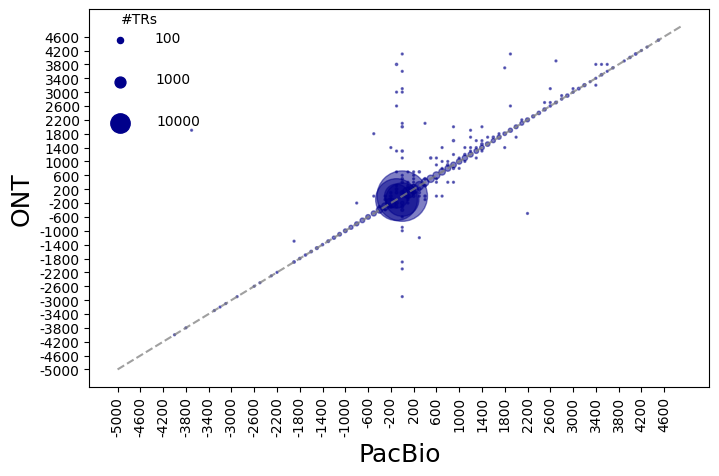

In [17]:
# interesting = both_with_calls[(both_with_calls['gb_ont_mean'].abs() > 10) | 
#                               (both_with_calls['gb_pacbio_mean'].abs() > 10)]
interesting = both_with_calls
bubble_df = bubble_df_maker(interesting, 5000, 100,'gb_pacbio_mean', 'gb_ont_mean')
bubble_plot(bubble_df,5000,100,[100,1000,10000],"", "PacBio", "ONT")